## Import Libraries 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import altair as alt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Read Data 

In [4]:
train = pd.read_csv("https://s3.amazonaws.com/backup.deltax.com/dump/data.csv")
test = pd.read_csv("https://s3.amazonaws.com/backup.deltax.com/dump/predict.csv")
submission = pd.read_csv("https://s3.amazonaws.com/backup.deltax.com/dump/sample_submission.csv")

In [5]:
train.head()

date    campaign    adgroup    ad  impressions  clicks  cost  \
0  2020-08-01  campaign 1  adgroup 1  ad 1           24       6  0.08   
1  2020-08-01  campaign 1  adgroup 2  ad 1            1       0  0.00   
2  2020-08-01  campaign 1  adgroup 3  ad 1           13       4  0.04   
3  2020-08-01  campaign 1  adgroup 4  ad 1            5       4  0.08   
4  2020-08-01  campaign 1  adgroup 1  ad 2          247     126  1.29   

   conversions  revenue  
0            0     0.00  
1            0     0.00  
2            0     0.00  
3            0     0.00  
4            4   925.71

In [6]:
train.dtypes

date            object
campaign        object
adgroup         object
ad              object
impressions      int64
clicks           int64
cost           float64
conversions      int64
revenue        float64
dtype: object

### Convert DateTime

In [7]:
train["date"] = train["date"].apply(pd.to_datetime)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4571 entries, 0 to 4570
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         4571 non-null   datetime64[ns]
 1   campaign     4571 non-null   object        
 2   adgroup      4571 non-null   object        
 3   ad           4571 non-null   object        
 4   impressions  4571 non-null   int64         
 5   clicks       4571 non-null   int64         
 6   cost         4571 non-null   float64       
 7   conversions  4571 non-null   int64         
 8   revenue      4571 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 321.5+ KB


# Exploratory Data Analysis

In [9]:
train["adgroup"].value_counts()

adgroup 3    1672
adgroup 1    1314
adgroup 4     858
adgroup 2     727
Name: adgroup, dtype: int64

In [10]:
train["ad"].nunique()

70

## Check Duplicates 

#### Here we check for the duplicate rows in the combination of 'date', 'campaign','adgroup','ad' and we found there are 334 (334) rows are duplicate.

In [11]:
duplicateRowsDF = train[train.duplicated(['date', 'campaign','adgroup','ad'])]

In [12]:
duplicateRowsDF

date    campaign    adgroup     ad  impressions  clicks  cost  \
460  2020-08-25  campaign 1  adgroup 4  ad 12            2       1  0.01   
461  2020-08-25  campaign 1  adgroup 1  ad 12          270      97  1.14   
464  2020-08-25  campaign 1  adgroup 3  ad 12           50      17  0.19   
472  2020-08-26  campaign 1  adgroup 3  ad 12          494     236  2.51   
473  2020-08-26  campaign 1  adgroup 2  ad 12            1       0  0.00   
...         ...         ...        ...    ...          ...     ...   ...   
4265 2021-02-16  campaign 1  adgroup 1  ad 70            1       0  0.00   
4268 2021-02-16  campaign 1  adgroup 2  ad 68            2       0  0.00   
4269 2021-02-16  campaign 1  adgroup 1  ad 68          348     167  3.68   
4272 2021-02-16  campaign 1  adgroup 3  ad 68          435     220  3.13   
4273 2021-02-16  campaign 1  adgroup 4  ad 68           18      11  0.43   

      conversions  revenue  
460             0     0.00  
461             5  1047.48  
464             0     0.00  
472             8  2006.02  
473             0     0.00  
...           ...      ...  
4265            0     0.00  
4268            0     0.00  
4269           13  1852.84  
4272           14  1993.35  
4273            1   259.25  

[334 rows x 9 columns]

### Convert DataFrame into SQL Table

In [13]:
conn = sqlite3.connect('testDB')
c = conn.cursor()

In [14]:
c.execute("""drop table train_df""")
conn.commit()
train.to_sql('train_df', conn)

###  Query for dealing duplicate and efficiency materics calculation:-

#### to handle these duplicate value we decided to combine those duplicate and sum their raw or efficiency metrics.

In [15]:
query = """select t1.date, t1.campaign, t1.adgroup, t1.ad, sum(t1.impressions) as impressions, 
                   sum(t1.clicks) as clicks, sum(t1.cost) as cost, 
                   sum(t1.conversions) as conversions, sum(t1.revenue) as revenue, 
                   sum(t1.clicks)/cast(sum(t1.impressions) as float) as CTR,
                   sum(t1.cost)/sum(t1.clicks) as CPC,
                   sum(t1.cost)/sum(t1.conversions) as CPA,
                   sum(t1.revenue)/sum(t1.cost) as ROI
           from train_df as t1
           group by t1.date, t1.campaign, t1.adgroup, t1.ad"""
final_train = pd.read_sql(query, conn)

#### Now in our final_train DataFrame, their are 334 record less than train DataFrame. 

In [16]:
final_train.shape, train.shape

((4237, 13), (4571, 9))

In [17]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  \
0  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 1           24       6   
1  2020-08-01 00:00:00  campaign 1  adgroup 1  ad 10            5       2   
2  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 2          247     126   
3  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 3          129      52   
4  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 7           26      10   

   cost  conversions  revenue       CTR       CPC     CPA         ROI  
0  0.08            0     0.00  0.250000  0.013333     NaN    0.000000  
1  0.02            0     0.00  0.400000  0.010000     NaN    0.000000  
2  1.29            4   925.71  0.510121  0.010238  0.3225  717.604651  
3  0.58            0     0.00  0.403101  0.011154     NaN    0.000000  
4  0.10            0     0.00  0.384615  0.010000     NaN    0.000000

## Data Analysis : - Based on this exercise we get to know about how revenue value (revenue = 0), spread accross adgroups 

In [18]:
final_train["adgroup"].value_counts()

adgroup 3    1572
adgroup 1    1211
adgroup 4     784
adgroup 2     670
Name: adgroup, dtype: int64

In [19]:
final_train.shape

(4237, 13)

### Dataset with revenue = 0 

In [20]:
rev_0 = final_train.loc[final_train['revenue'].isin([0])]

### Shape of data which has 0 revenue : - More than 50% data has 0 revenue

In [21]:
rev_0.shape

(2957, 13)

#### Dataset of Different Adgroup 

In [22]:
adgroup1 = final_train.loc[final_train['adgroup'].isin(["adgroup 1"])]
adgroup2 = final_train.loc[final_train['adgroup'].isin(["adgroup 2"])]
adgroup3 = final_train.loc[final_train['adgroup'].isin(["adgroup 3"])]
adgroup4 = final_train.loc[final_train['adgroup'].isin(["adgroup 4"])]

#### Dataset of different adgroup with 0 revenue 

In [23]:
adgroup1_rev_0 = rev_0.loc[rev_0['adgroup'].isin(["adgroup 1"])]
adgroup2_rev_0 = rev_0.loc[rev_0['adgroup'].isin(["adgroup 2"])]
adgroup3_rev_0 = rev_0.loc[rev_0['adgroup'].isin(["adgroup 3"])]
adgroup4_rev_0 = rev_0.loc[rev_0['adgroup'].isin(["adgroup 4"])]

#### Shape of 0 revenue Data

In [24]:
adgroup1_rev_0.shape,adgroup2_rev_0.shape,adgroup3_rev_0.shape,adgroup4_rev_0.shape

((719, 13), (648, 13), (870, 13), (720, 13))

### Percentage of 0 revenue in adgroup 1

In [25]:
adgroup1_rev_0.revenue.value_counts()/len(adgroup1)

0.0    0.593724
Name: revenue, dtype: float64

### Percentage of 0 revenue in adgroup 2

In [26]:
adgroup2_rev_0.revenue.value_counts()/len(adgroup2)

0.0    0.967164
Name: revenue, dtype: float64

### Percentage of 0 revenue in adgroup 3

In [27]:
adgroup3_rev_0.revenue.value_counts()/len(adgroup3)

0.0    0.553435
Name: revenue, dtype: float64

### Percentage of 0 revenue in adgroup 4

In [28]:
adgroup4_rev_0.revenue.value_counts()/len(adgroup4)

0.0    0.918367
Name: revenue, dtype: float64

## Note - So based on this exercise we get to know the "Revenue" of Adgroup 2 and Adgroup 4 has more than 90% times is 0. 

In [29]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  \
0  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 1           24       6   
1  2020-08-01 00:00:00  campaign 1  adgroup 1  ad 10            5       2   
2  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 2          247     126   
3  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 3          129      52   
4  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 7           26      10   

   cost  conversions  revenue       CTR       CPC     CPA         ROI  
0  0.08            0     0.00  0.250000  0.013333     NaN    0.000000  
1  0.02            0     0.00  0.400000  0.010000     NaN    0.000000  
2  1.29            4   925.71  0.510121  0.010238  0.3225  717.604651  
3  0.58            0     0.00  0.403101  0.011154     NaN    0.000000  
4  0.10            0     0.00  0.384615  0.010000     NaN    0.000000

### Distribution of data adGroup wise 

In [30]:
input_dropdown = alt.binding_select(options=['adgroup 1','adgroup 2','adgroup 3','adgroup 4'])
selection = alt.selection_single(fields=['adgroup'], bind=input_dropdown, name='group of ')
color = alt.condition(selection,
                    alt.Color('adgroup:N', legend=None),
                    alt.value('lightgray'))

alt.Chart(final_train).mark_point().encode(
    alt.X('clicks'),
    alt.Y('revenue'),
    alt.Size('cost'),
    alt.Color('adgroup'),
    tooltip = [alt.Tooltip('ad'),
               alt.Tooltip('clicks:Q'),
               alt.Tooltip('revenue:Q'),
               alt.Tooltip('cost:Q')]
).add_selection(
    selection
).transform_filter(
    selection
)

alt.Chart(...)

In [31]:
final_train.describe()

impressions       clicks         cost  conversions       revenue  \
count  4237.000000  4237.000000  4237.000000  4237.000000   4237.000000   
mean     99.938164    46.757376     3.021621     1.444654    250.143137   
std     217.927633   110.038510    15.629210     5.798885   1226.195439   
min       1.000000     0.000000     0.000000     0.000000      0.000000   
25%       6.000000     2.000000     0.040000     0.000000      0.000000   
50%      17.000000     7.000000     0.210000     0.000000      0.000000   
75%      90.000000    41.000000     1.410000     1.000000     99.000000   
max    3447.000000  1874.000000   572.020000   100.000000  26712.770000   

               CTR          CPC          CPA           ROI  
count  4237.000000  3850.000000  1283.000000   3850.000000  
mean      0.438474     0.063873     1.906947    165.262716  
std       0.224243     0.138775     3.403451    824.723714  
min       0.000000     0.010000     0.010000      0.000000  
25%       0.333333     0.011578     0.332409      0.000000  
50%       0.450311     0.017500     0.770000      0.000000  
75%       0.533333     0.063982     1.960000     58.577941  
max       2.000000     3.810000    57.450000  24942.000000

## Comparision of Raw metrics based on Adgroups 

#### Impressions - Number of time the ad was shown

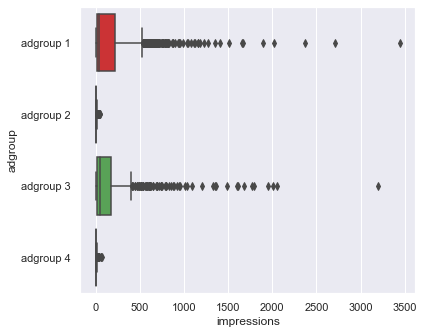

In [32]:
sns.set(rc={'figure.figsize':(6,5.27)})
ax = sns.boxplot(y="adgroup", x="impressions", data=final_train, orient="h", palette="Set1")

#### Clicks - Number of time the ad clicked shown

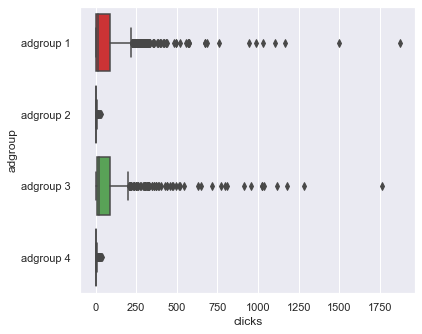

In [33]:
ax = sns.boxplot(y="adgroup", x="clicks", data=final_train, orient="h", palette="Set1")

#### Cost - Amount spent to show ad

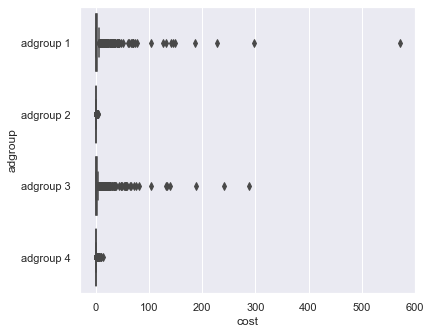

In [34]:
ax = sns.boxplot(y="adgroup", x="cost", data=final_train, orient="h", palette="Set1")

#### Conversions - Number of transactions received (higher the better)

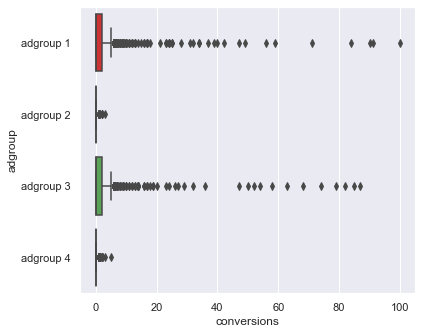

In [35]:
ax = sns.boxplot(y="adgroup", x="conversions", data=final_train, orient="h", palette="Set1")

#### Revenue - Total value of transactions received (higher the better)

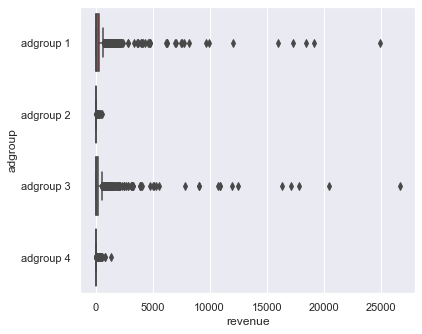

In [36]:
ax = sns.boxplot(y="adgroup", x="revenue", data=final_train, orient="h", palette="Set1")

In [37]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  \
0  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 1           24       6   
1  2020-08-01 00:00:00  campaign 1  adgroup 1  ad 10            5       2   
2  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 2          247     126   
3  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 3          129      52   
4  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 7           26      10   

   cost  conversions  revenue       CTR       CPC     CPA         ROI  
0  0.08            0     0.00  0.250000  0.013333     NaN    0.000000  
1  0.02            0     0.00  0.400000  0.010000     NaN    0.000000  
2  1.29            4   925.71  0.510121  0.010238  0.3225  717.604651  
3  0.58            0     0.00  0.403101  0.011154     NaN    0.000000  
4  0.10            0     0.00  0.384615  0.010000     NaN    0.000000

## Relationship between Raw metrics based on their Adgroups. 

<AxesSubplot:xlabel='clicks', ylabel='revenue'>

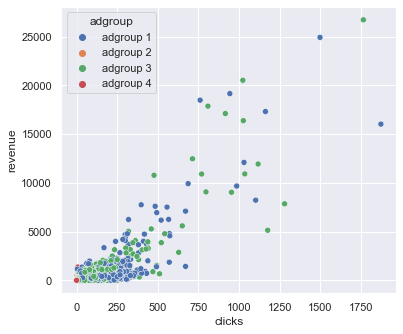

In [38]:
sns.scatterplot(x='clicks', y='revenue', hue = 'adgroup', data = final_train)

#### Based on this graph we can easily say their are a linear relationship between impressions and clicks.

<AxesSubplot:xlabel='impressions', ylabel='clicks'>

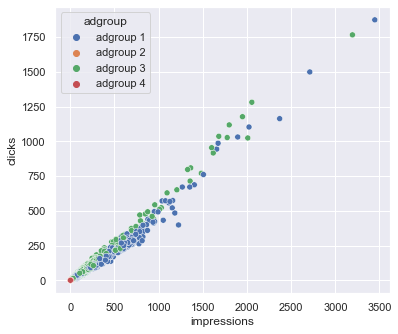

In [39]:
sns.scatterplot(x='impressions', y='clicks', hue = 'adgroup', data = final_train)

<AxesSubplot:xlabel='impressions', ylabel='cost'>

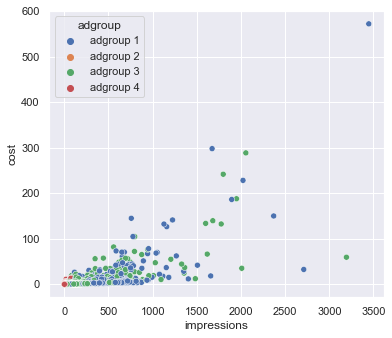

In [40]:
sns.scatterplot(x='impressions', y='cost', hue = 'adgroup', data = final_train)

<AxesSubplot:xlabel='clicks', ylabel='revenue'>

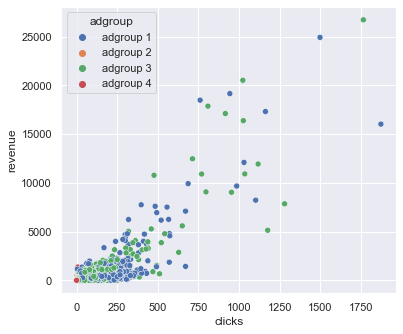

In [41]:
sns.scatterplot(x='clicks', y='revenue', hue = 'adgroup', data = final_train)

<AxesSubplot:xlabel='cost', ylabel='revenue'>

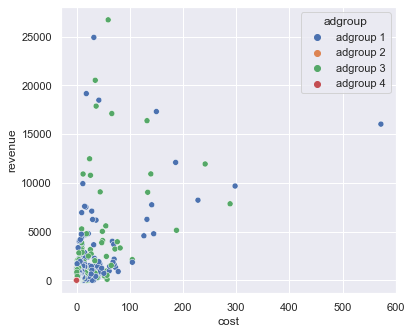

In [42]:
sns.scatterplot(x='cost', y='revenue', hue = 'adgroup', data = final_train)

#### Based on the above exercise, we get to know how data points are spread in a raw matrix based on their adgroup. Some of them have a linear relationship, but others are not linearly distributed.

In [43]:
final_train.isnull().sum()

date              0
campaign          0
adgroup           0
ad                0
impressions       0
clicks            0
cost              0
conversions       0
revenue           0
CTR               0
CPC             387
CPA            2954
ROI             387
dtype: int64

### Distributon of efficiency metrics

Text(0.5, 0, 'CTR')

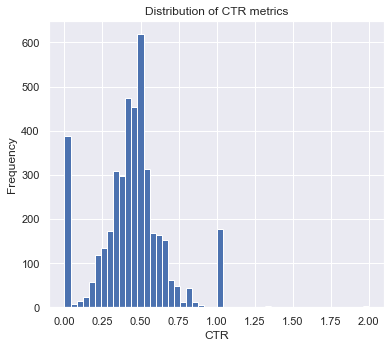

In [44]:
ax = final_train["CTR"].plot(kind = 'hist',bins = 50,title='Distribution of CTR metrics')
ax.set_xlabel("CTR")

Text(0.5, 0, 'CPC')

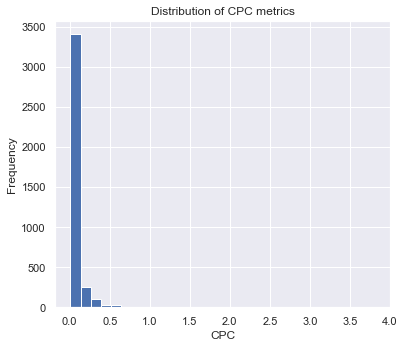

In [45]:
ax = final_train["CPC"].plot(kind = 'hist',bins = 30,title='Distribution of CPC metrics')
ax.set_xlabel("CPC")

Text(0.5, 0, 'CPA')

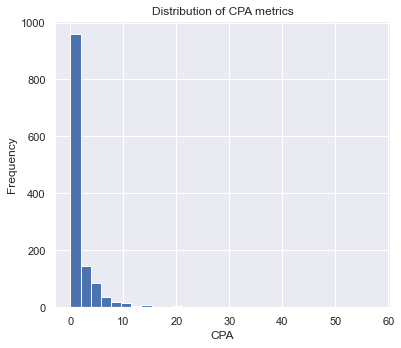

In [46]:
ax = final_train["CPA"].plot(kind = 'hist',bins = 30,title='Distribution of CPA metrics')
ax.set_xlabel("CPA")

Text(0.5, 0, 'ROI')

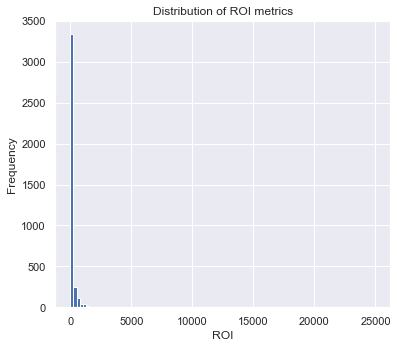

In [47]:
ax = final_train["ROI"].plot(kind = 'hist',bins = 100,title='Distribution of ROI metrics')
ax.set_xlabel("ROI")

## Comparision of Efficiency metrics in different Adgroups 

#### CTR : - Clicks / Impression (higher the better - used to evaluate if the users find the ad relevant)

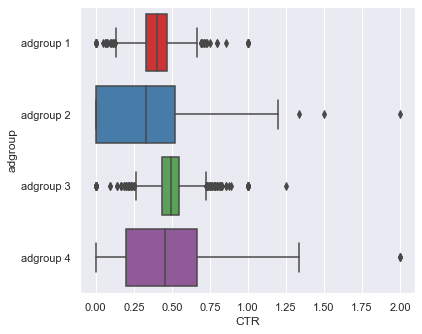

In [48]:
ax = sns.boxplot(y="adgroup", x="CTR", data=final_train, orient="h", palette="Set1")

#### CPC : - Cost / Click (lower the better - used to evaluate if the cost for getting a click)

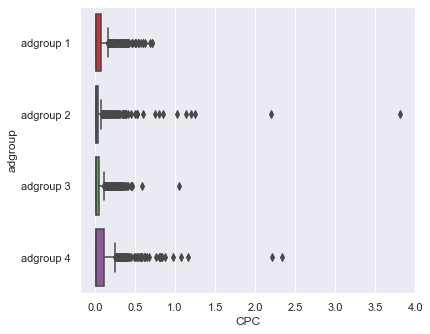

In [49]:
ax = sns.boxplot(y="adgroup", x="CPC", data=final_train, orient="h", palette="Set1")

#### CPA : - Cost / Conversion (lower the better - used to evaluate if the cost for getting a conversion)

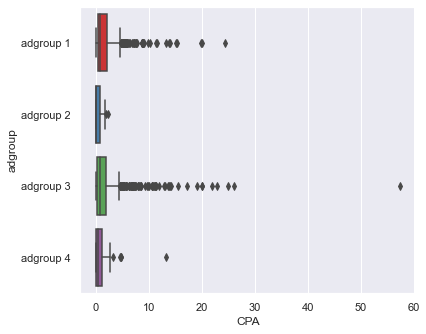

In [50]:
ax = sns.boxplot(y="adgroup", x="CPA", data=final_train, orient="h", palette="Set1")

#### ROI : - Revenue/Cost (higher the better - used to evaluate the effectiveness of the advertising budget spent)

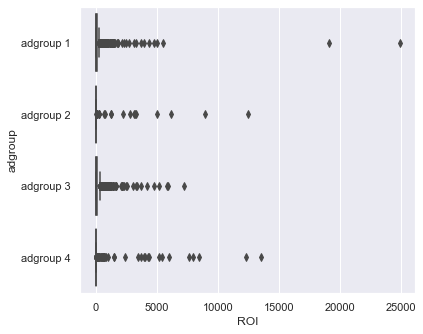

In [51]:
ax = sns.boxplot(y="adgroup", x="ROI", data=final_train, orient="h", palette="Set1")

In [52]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  \
0  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 1           24       6   
1  2020-08-01 00:00:00  campaign 1  adgroup 1  ad 10            5       2   
2  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 2          247     126   
3  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 3          129      52   
4  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 7           26      10   

   cost  conversions  revenue       CTR       CPC     CPA         ROI  
0  0.08            0     0.00  0.250000  0.013333     NaN    0.000000  
1  0.02            0     0.00  0.400000  0.010000     NaN    0.000000  
2  1.29            4   925.71  0.510121  0.010238  0.3225  717.604651  
3  0.58            0     0.00  0.403101  0.011154     NaN    0.000000  
4  0.10            0     0.00  0.384615  0.010000     NaN    0.000000

## Monthly Level Analysis 

In [53]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  \
0  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 1           24       6   
1  2020-08-01 00:00:00  campaign 1  adgroup 1  ad 10            5       2   
2  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 2          247     126   
3  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 3          129      52   
4  2020-08-01 00:00:00  campaign 1  adgroup 1   ad 7           26      10   

   cost  conversions  revenue       CTR       CPC     CPA         ROI  
0  0.08            0     0.00  0.250000  0.013333     NaN    0.000000  
1  0.02            0     0.00  0.400000  0.010000     NaN    0.000000  
2  1.29            4   925.71  0.510121  0.010238  0.3225  717.604651  
3  0.58            0     0.00  0.403101  0.011154     NaN    0.000000  
4  0.10            0     0.00  0.384615  0.010000     NaN    0.000000

In [54]:
final_train['date'] = pd.to_datetime(final_train['date'])

In [55]:
final_train['year'] = final_train['date'].dt.year
final_train['month'] = final_train['date'].dt.month

In [56]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  cost  \
0 2020-08-01  campaign 1  adgroup 1   ad 1           24       6  0.08   
1 2020-08-01  campaign 1  adgroup 1  ad 10            5       2  0.02   
2 2020-08-01  campaign 1  adgroup 1   ad 2          247     126  1.29   
3 2020-08-01  campaign 1  adgroup 1   ad 3          129      52  0.58   
4 2020-08-01  campaign 1  adgroup 1   ad 7           26      10  0.10   

   conversions  revenue       CTR       CPC     CPA         ROI  year  month  
0            0     0.00  0.250000  0.013333     NaN    0.000000  2020      8  
1            0     0.00  0.400000  0.010000     NaN    0.000000  2020      8  
2            4   925.71  0.510121  0.010238  0.3225  717.604651  2020      8  
3            0     0.00  0.403101  0.011154     NaN    0.000000  2020      8  
4            0     0.00  0.384615  0.010000     NaN    0.000000  2020      8

In [57]:
final_train.dtypes

date           datetime64[ns]
campaign               object
adgroup                object
ad                     object
impressions             int64
clicks                  int64
cost                  float64
conversions             int64
revenue               float64
CTR                   float64
CPC                   float64
CPA                   float64
ROI                   float64
year                    int64
month                   int64
dtype: object

In [58]:
final_train["month"] = final_train["month"].astype(str)
final_train["year"] = final_train["year"].astype(str)

In [59]:
final_train.dtypes

date           datetime64[ns]
campaign               object
adgroup                object
ad                     object
impressions             int64
clicks                  int64
cost                  float64
conversions             int64
revenue               float64
CTR                   float64
CPC                   float64
CPA                   float64
ROI                   float64
year                   object
month                  object
dtype: object

In [60]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  cost  \
0 2020-08-01  campaign 1  adgroup 1   ad 1           24       6  0.08   
1 2020-08-01  campaign 1  adgroup 1  ad 10            5       2  0.02   
2 2020-08-01  campaign 1  adgroup 1   ad 2          247     126  1.29   
3 2020-08-01  campaign 1  adgroup 1   ad 3          129      52  0.58   
4 2020-08-01  campaign 1  adgroup 1   ad 7           26      10  0.10   

   conversions  revenue       CTR       CPC     CPA         ROI  year month  
0            0     0.00  0.250000  0.013333     NaN    0.000000  2020     8  
1            0     0.00  0.400000  0.010000     NaN    0.000000  2020     8  
2            4   925.71  0.510121  0.010238  0.3225  717.604651  2020     8  
3            0     0.00  0.403101  0.011154     NaN    0.000000  2020     8  
4            0     0.00  0.384615  0.010000     NaN    0.000000  2020     8

In [61]:
final_train["dateOFmonth"] = final_train["date"].dt.day

In [62]:
final_train.head()

date    campaign    adgroup     ad  impressions  clicks  cost  \
0 2020-08-01  campaign 1  adgroup 1   ad 1           24       6  0.08   
1 2020-08-01  campaign 1  adgroup 1  ad 10            5       2  0.02   
2 2020-08-01  campaign 1  adgroup 1   ad 2          247     126  1.29   
3 2020-08-01  campaign 1  adgroup 1   ad 3          129      52  0.58   
4 2020-08-01  campaign 1  adgroup 1   ad 7           26      10  0.10   

   conversions  revenue       CTR       CPC     CPA         ROI  year month  \
0            0     0.00  0.250000  0.013333     NaN    0.000000  2020     8   
1            0     0.00  0.400000  0.010000     NaN    0.000000  2020     8   
2            4   925.71  0.510121  0.010238  0.3225  717.604651  2020     8   
3            0     0.00  0.403101  0.011154     NaN    0.000000  2020     8   
4            0     0.00  0.384615  0.010000     NaN    0.000000  2020     8   

   dateOFmonth  
0            1  
1            1  
2            1  
3            1  
4            1

### Impression based on Data Of a Month 

In [63]:
new = final_train.pivot_table(index=["dateOFmonth"], 
               values=["impressions"], aggfunc=np.var)

In [64]:
new.reset_index(inplace = True)

In [65]:
new.sort_values(by = "impressions", ascending=False)

dateOFmonth    impressions
26           27  185355.381890
8             9  174052.999942
25           26  126063.568000
9            10   99281.062881
7             8   75438.572213
27           28   69088.891486
24           25   68635.232617
12           13   67407.142499
10           11   48804.641791
30           31   46431.573760
28           29   41545.690855
6             7   40343.108279
29           30   38591.643783
11           12   34950.472441
23           24   34497.442816
5             6   29862.191489
13           14   27492.452233
15           16   26843.242897
14           15   25919.908860
22           23   24749.375766
4             5   24308.141591
0             1   24229.640804
1             2   21632.968391
16           17   20682.156107
19           20   19997.570517
20           21   19363.339847
2             3   19262.007641
18           19   18995.395594
21           22   18779.968682
17           18   18265.182475
3             4   17927.966736

In [66]:
final_train.to_excel("data_train.xlsx", index = False)

In [67]:
new_train = pd.read_excel("data_train.xlsx")

In [68]:
new_train.tail()

date    campaign    adgroup     ad  impressions  clicks  cost  \
4232 2021-02-28  campaign 1  adgroup 3   ad 8          261     106  1.37   
4233 2021-02-28  campaign 1  adgroup 4   ad 1            4       0  0.00   
4234 2021-02-28  campaign 1  adgroup 4   ad 2            2       0  0.00   
4235 2021-02-28  campaign 1  adgroup 4   ad 3            9       2  0.03   
4236 2021-02-28  campaign 1  adgroup 4  ad 55            1       0  0.00   

      conversions  revenue       CTR       CPC       CPA         ROI  year  \
4232            3   404.17  0.406130  0.012925  0.456667  295.014599  2021   
4233            0     0.00  0.000000       NaN       NaN         NaN  2021   
4234            0     0.00  0.000000       NaN       NaN         NaN  2021   
4235            0     0.00  0.222222  0.015000       NaN    0.000000  2021   
4236            0     0.00  0.000000       NaN       NaN         NaN  2021   

      month  dateOFmonth  
4232      2           28  
4233      2           28  
4234      2           28  
4235      2           28  
4236      2           28

### Pivot the Data into Monthly level 

In [69]:
new = new_train.pivot_table(index=["year","month","adgroup","ad"], 
               values=["impressions","clicks","cost","conversions",
                       "revenue","CTR","CPC","CPA","ROI"], aggfunc=np.sum)

In [70]:
new

CPA       CPC       CTR          ROI  clicks  \
year month adgroup   ad                                                         
2020 8     adgroup 1 ad 1   1.855000  0.297801  9.335119  6217.116363     440   
                     ad 10  0.350000  0.294210  9.553772  9954.708333     184   
                     ad 11  2.660000  0.104627  1.429528   955.728624     293   
                     ad 12  6.647083  0.311711  1.266398  1057.115576     362   
                     ad 13  9.659592  0.475880  1.717022   502.194091    1367   
...                              ...       ...       ...          ...     ...   
2021 2     adgroup 4 ad 66  0.000000  0.078000  0.666667     0.000000       7   
                     ad 67  0.000000  0.095000  0.500000     0.000000       2   
                     ad 68  0.450000  0.080833  0.785714   576.111111      15   
                     ad 69  0.000000  0.016667  0.375000     0.000000       3   
                     ad 70  0.000000  0.043333  0.250000     0.000000       3   

                            conversions    cost  impressions   revenue  
year month adgroup   ad                                                 
2020 8     adgroup 1 ad 1            10    5.19         1126   1501.42  
                     ad 10            6    2.22          490    847.97  
                     ad 11            7    5.31          610   1598.58  
                     ad 12           13   20.02          862   3189.32  
                     ad 13           76  175.18         3196  14732.52  
...                                 ...     ...          ...       ...  
2021 2     adgroup 4 ad 66            0    0.27           22      0.00  
                     ad 67            0    0.19            4      0.00  
                     ad 68            1    0.58           35    259.25  
                     ad 69            0    0.05            8      0.00  
                     ad 70            0    0.13           12      0.00  

[405 rows x 9 columns]

In [71]:
new.columns

Index(['CPA', 'CPC', 'CTR', 'ROI', 'clicks', 'conversions', 'cost',
       'impressions', 'revenue'],
      dtype='object')

In [72]:
new.reset_index(inplace = True)

In [73]:
new.head()

year  month    adgroup     ad       CPA       CPC       CTR          ROI  \
0  2020      8  adgroup 1   ad 1  1.855000  0.297801  9.335119  6217.116363   
1  2020      8  adgroup 1  ad 10  0.350000  0.294210  9.553772  9954.708333   
2  2020      8  adgroup 1  ad 11  2.660000  0.104627  1.429528   955.728624   
3  2020      8  adgroup 1  ad 12  6.647083  0.311711  1.266398  1057.115576   
4  2020      8  adgroup 1  ad 13  9.659592  0.475880  1.717022   502.194091   

   clicks  conversions    cost  impressions   revenue  
0     440           10    5.19         1126   1501.42  
1     184            6    2.22          490    847.97  
2     293            7    5.31          610   1598.58  
3     362           13   20.02          862   3189.32  
4    1367           76  175.18         3196  14732.52

In [74]:
new["month"].value_counts()

11    75
10    61
2     60
1     59
9     56
12    50
8     44
Name: month, dtype: int64

In [75]:
new['month'] = new['month'].apply(str)

In [76]:
new['month'] = new['month'].replace(['8','9','10','11','12','1','2'],
                              ['August','September','October','November','December','January','February'])

In [77]:
new.head()

year   month    adgroup     ad       CPA       CPC       CTR          ROI  \
0  2020  August  adgroup 1   ad 1  1.855000  0.297801  9.335119  6217.116363   
1  2020  August  adgroup 1  ad 10  0.350000  0.294210  9.553772  9954.708333   
2  2020  August  adgroup 1  ad 11  2.660000  0.104627  1.429528   955.728624   
3  2020  August  adgroup 1  ad 12  6.647083  0.311711  1.266398  1057.115576   
4  2020  August  adgroup 1  ad 13  9.659592  0.475880  1.717022   502.194091   

   clicks  conversions    cost  impressions   revenue  
0     440           10    5.19         1126   1501.42  
1     184            6    2.22          490    847.97  
2     293            7    5.31          610   1598.58  
3     362           13   20.02          862   3189.32  
4    1367           76  175.18         3196  14732.52

### Yearly Analysis 

In [78]:
select_year = alt.selection_single(
    name='Select', fields=['year'], init={'year': 2020},
    bind=alt.binding_range(min=2020, max=2021, step=0)
)

alt.Chart(new).mark_point(filled=True).encode(
    alt.X('clicks'),
    alt.Y('revenue'),
    alt.Size('cost'),
    alt.Color('adgroup'),
    tooltip = [alt.Tooltip('ad'),
               alt.Tooltip('clicks:Q'),
               alt.Tooltip('revenue:Q'),
               alt.Tooltip('cost:Q')]
).add_selection(select_year).transform_filter(select_year)

alt.Chart(...)

In [79]:
brush = alt.selection(type='interval')

points = alt.Chart(new).mark_point().encode(
    x='clicks',
    y='conversions',
    color=alt.condition(brush, 'adgroup', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart(new).mark_bar().encode(
    y='adgroup',
    color='adgroup',
    x='count(adgroup)'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

In [80]:
brush = alt.selection(type='interval')

points = alt.Chart(new).mark_point().encode(
    x='clicks',
    y='conversions',
    color=alt.condition(brush, 'adgroup', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart(new).mark_bar().encode(
    y='adgroup',
    color='adgroup',
    x='sum(revenue)'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

In [81]:
input_dropdown = alt.binding_select(options=['adgroup 1','adgroup 2','adgroup 3','adgroup 4'])
selection = alt.selection_single(fields=['adgroup'], bind=input_dropdown, name='group of ')
color = alt.condition(selection,
                    alt.Color('adgroup:N', legend=None),
                    alt.value('lightgray'))

alt.Chart(final_train).mark_point().encode(
    alt.X('impressions'),
    alt.Y('clicks'),
    alt.Size('cost'),
    alt.Color('adgroup'),
    tooltip = [alt.Tooltip('ad'),
               alt.Tooltip('clicks:Q'),
               alt.Tooltip('revenue:Q'),
               alt.Tooltip('cost:Q')]
).add_selection(
    selection
).transform_filter(
    selection
)

alt.Chart(...)

### Monthly trend of raw metrics 

<AxesSubplot:xlabel='month', ylabel='revenue'>

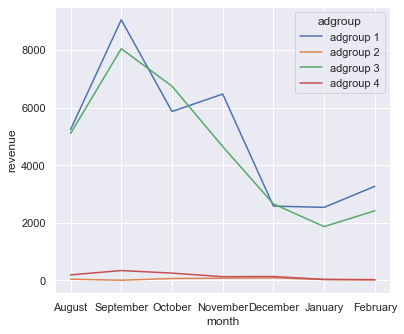

In [82]:
sns.lineplot(x="month", y="revenue",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='impressions'>

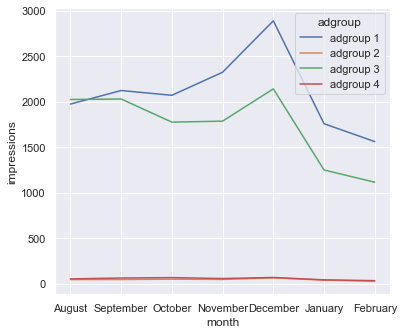

In [83]:
sns.lineplot(x="month", y="impressions",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='cost'>

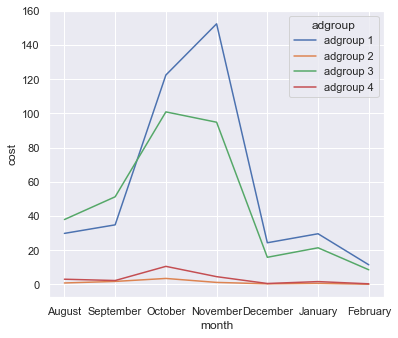

In [84]:
sns.lineplot(x="month", y="cost",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='conversions'>

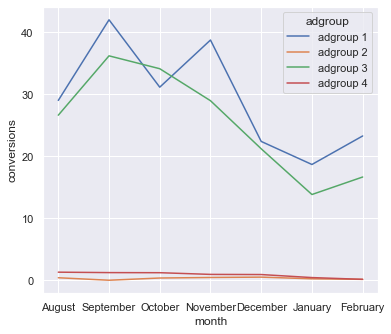

In [85]:
sns.lineplot(x="month", y="conversions",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='clicks'>

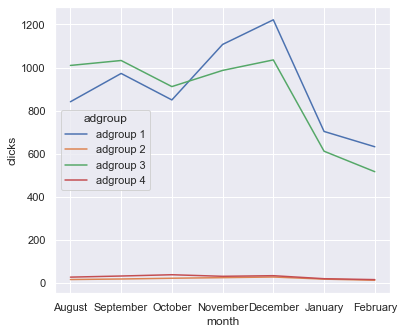

In [86]:
sns.lineplot(x="month", y="clicks",
             hue="adgroup",ci=None,
             data=new)

#### Based on the above exercise we get to know the monthly level trend of raw metrics. Now we know which month there is a spike in the trend.

## Monthly trend of efficiency metrics 

<AxesSubplot:xlabel='month', ylabel='CPA'>

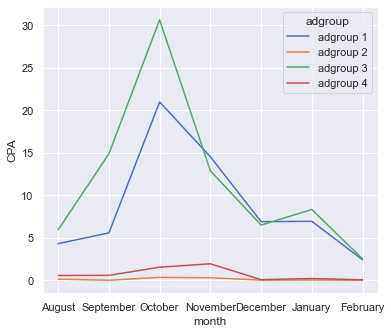

In [87]:
sns.lineplot(x="month", y="CPA",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='CPC'>

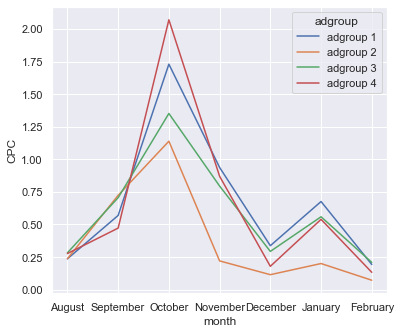

In [88]:
sns.lineplot(x="month", y="CPC",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='CTR'>

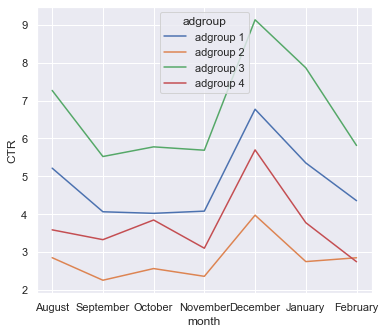

In [89]:
sns.lineplot(x="month", y="CTR",
             hue="adgroup",ci=None,
             data=new)

<AxesSubplot:xlabel='month', ylabel='ROI'>

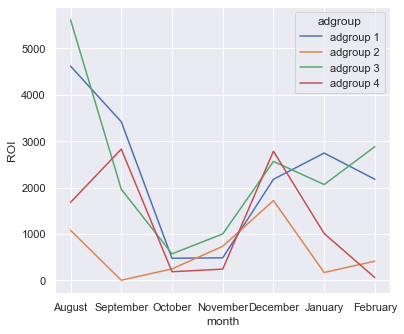

In [90]:
sns.lineplot(x="month", y="ROI",
             hue="adgroup",ci=None,
             data=new)

### Based on the above exercise we get to know the monthly level trend of efficiency metrics. Now we know which month there is a spike in the trend.

In [91]:
new.head()

year   month    adgroup     ad       CPA       CPC       CTR          ROI  \
0  2020  August  adgroup 1   ad 1  1.855000  0.297801  9.335119  6217.116363   
1  2020  August  adgroup 1  ad 10  0.350000  0.294210  9.553772  9954.708333   
2  2020  August  adgroup 1  ad 11  2.660000  0.104627  1.429528   955.728624   
3  2020  August  adgroup 1  ad 12  6.647083  0.311711  1.266398  1057.115576   
4  2020  August  adgroup 1  ad 13  9.659592  0.475880  1.717022   502.194091   

   clicks  conversions    cost  impressions   revenue  
0     440           10    5.19         1126   1501.42  
1     184            6    2.22          490    847.97  
2     293            7    5.31          610   1598.58  
3     362           13   20.02          862   3189.32  
4    1367           76  175.18         3196  14732.52

In [92]:
df_month = new.pivot_table(index=["year","adgroup","month"], 
               values=["impressions","clicks","cost","conversions",
                       "revenue","CTR","CPC","CPA","ROI"], aggfunc=np.sum)

In [93]:
df_month

CPA        CPC         CTR           ROI  \
year adgroup   month                                                        
2020 adgroup 1 August      47.310565   2.603907   57.351139  50795.971870   
               December    89.522890   4.386375   88.012016  28307.645297   
               November   275.840920  17.812713   77.490309   9185.654588   
               October    314.415895  25.943009   60.309221   7111.247997   
               September   77.952365   7.972627   56.868206  47865.874360   
     adgroup 2 August       1.260000   2.373404   28.487396  10769.378736   
               December     0.140000   1.150421   39.715267  17176.666667   
               November     5.201667   3.973180   42.422127  13174.823627   
               October      4.700000  15.942219   35.863888   3423.966652   
               September    0.000000   9.408095   29.297383      0.000000   
     adgroup 3 August      77.073492   3.677575   94.461188  73032.426308   
               December    97.222774   4.403168  136.983926  38452.186963   
               November   270.411816  16.690497  119.437322  20974.080049   
               October    551.186248  24.325874  103.978416  10255.054189   
               September  237.806010  11.288132   88.337232  31413.788726   
     adgroup 4 August       5.603000   2.771167   35.845517  16796.739917   
               December     0.860000   2.150461   68.360221  33398.321678   
               November    32.840000  14.786425   52.685568   4070.427439   
               October     21.443333  28.977970   53.821062   2570.071572   
               September    7.455000   6.140609   43.226926  36763.610865   
2021 adgroup 1 February    36.166685   2.893928   65.320543  32661.826366   
               January    103.942620  10.140980   80.272217  41141.856627   
     adgroup 2 February     0.110000   1.014869   39.859668   5770.000000   
               January      0.410000   2.607071   35.699731   2170.107843   
     adgroup 3 February    42.766922   3.556350   98.814515  49014.608440   
               January    141.435833   9.505745  133.675304  35089.607035   
     adgroup 4 February     0.710000   1.863071   38.389322    783.803419   
               January      2.825000   7.551571   52.829151  14091.709279   

                          clicks  conversions     cost  impressions    revenue  
year adgroup   month                                                            
2020 adgroup 1 August       9248          319   328.74        21698   57572.97  
               December    15884          291   317.31        37533   33487.94  
               November    21038          736  2896.48        44127  122941.33  
               October     12738          467  1837.32        31034   87956.23  
               September   13613          588   488.32        29699  126707.58  
     adgroup 2 August        141            4     8.91          451     372.59  
               December      258            5     4.10          635     833.60  
               November      410            8    21.94          834    1253.58  
               October       281            5    49.56          693     853.17  
               September     215            0    23.35          592       0.00  
     adgroup 3 August      13125          346   493.82        26296   66278.36  
               December    15529          318   238.66        32093   39774.47  
               November    20716          608  1992.71        37486   97529.61  
               October     16403          614  1816.78        31936  121392.41  
               September   16521          579   820.58        32452  128745.83  
     adgroup 4 August        252           13    30.88          524    1851.85  
               December      383           11     7.05          817    1544.10  
               November      494           16    77.95          956    2100.10  
               October       509           17   148.47          931    3463.61  
               Septem

In [94]:
df_month.reset_index(inplace = True)

In [95]:
df_month

year    adgroup      month         CPA        CPC         CTR  \
0   2020  adgroup 1     August   47.310565   2.603907   57.351139   
1   2020  adgroup 1   December   89.522890   4.386375   88.012016   
2   2020  adgroup 1   November  275.840920  17.812713   77.490309   
3   2020  adgroup 1    October  314.415895  25.943009   60.309221   
4   2020  adgroup 1  September   77.952365   7.972627   56.868206   
5   2020  adgroup 2     August    1.260000   2.373404   28.487396   
6   2020  adgroup 2   December    0.140000   1.150421   39.715267   
7   2020  adgroup 2   November    5.201667   3.973180   42.422127   
8   2020  adgroup 2    October    4.700000  15.942219   35.863888   
9   2020  adgroup 2  September    0.000000   9.408095   29.297383   
10  2020  adgroup 3     August   77.073492   3.677575   94.461188   
11  2020  adgroup 3   December   97.222774   4.403168  136.983926   
12  2020  adgroup 3   November  270.411816  16.690497  119.437322   
13  2020  adgroup 3    October  551.186248  24.325874  103.978416   
14  2020  adgroup 3  September  237.806010  11.288132   88.337232   
15  2020  adgroup 4     August    5.603000   2.771167   35.845517   
16  2020  adgroup 4   December    0.860000   2.150461   68.360221   
17  2020  adgroup 4   November   32.840000  14.786425   52.685568   
18  2020  adgroup 4    October   21.443333  28.977970   53.821062   
19  2020  adgroup 4  September    7.455000   6.140609   43.226926   
20  2021  adgroup 1   February   36.166685   2.893928   65.320543   
21  2021  adgroup 1    January  103.942620  10.140980   80.272217   
22  2021  adgroup 2   February    0.110000   1.014869   39.859668   
23  2021  adgroup 2    January    0.410000   2.607071   35.699731   
24  2021  adgroup 3   February   42.766922   3.556350   98.814515   
25  2021  adgroup 3    January  141.435833   9.505745  133.675304   
26  2021  adgroup 4   February    0.710000   1.863071   38.389322   
27  2021  adgroup 4    January    2.825000   7.551571   52.829151   

             ROI  clicks  conversions     cost  impressions    revenue  
0   50795.971870    9248          319   328.74        21698   57572.97  
1   28307.645297   15884          291   317.31        37533   33487.94  
2    9185.654588   21038          736  2896.48        44127  122941.33  
3    7111.247997   12738          467  1837.32        31034   87956.23  
4   47865.874360   13613          588   488.32        29699  126707.58  
5   10769.378736     141            4     8.91          451     372.59  
6   17176.666667     258            5     4.10          635     833.60  
7   13174.823627     410            8    21.94          834    1253.58  
8    3423.966652     281            5    49.56          693     853.17  
9       0.000000     215            0    23.35          592       0.00  
10  73032.426308   13125          346   493.82        26296   66278.36  
11  38452.186963   15529          318   238.66        32093   39774.47  
12  20974.080049   20716          608  1992.71        37486   97529.61  
13  10255.054189   16403          614  1816.78        31936  121392.41  
14  31413.788726   16521          579   820.58        32452  128745.83  
15  16796.739917     252           13    30.88          524    1851.85  
16  33398.321678     383           11     7.05          817    1544.10  
17   4070.427439     494           16    77.95          956    2100.10  
18   2570.071572     509           17   148.47          931    3463.61  
19  36763.610865     395           16    30.18          806    4376.32  
20  32661.826366    9472          349   172.76        23404   48975.01  
21  41141.856627   10540          280   445.09        26349   37989.79  
22   5770.000000     151            2     2.18          374     127.00  
23   2170.107843     207            3     8.96          502     310.33  
24  49014.608440    8764          283   146.28        18940   41023.71  
25  35089.607035   10383          235   364.88        21225   31683.25  
26    783.803419     191       

In [96]:
df_month.month.value_counts()

December     4
February     4
January      4
October      4
August       4
November     4
September    4
Name: month, dtype: int64

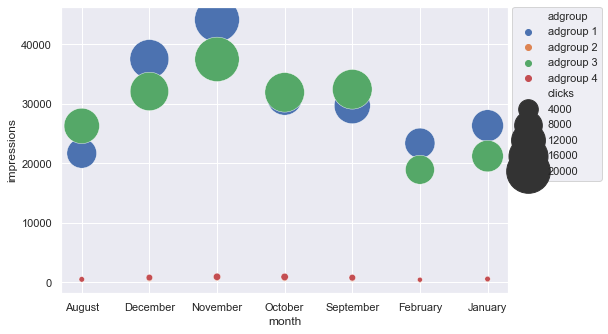

In [97]:
sns.set(rc={'figure.figsize':(8,5.27)})
sns.scatterplot(data=df_month, x="month", y="impressions", size="clicks", hue="adgroup", legend="brief", sizes=(20, 2000))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

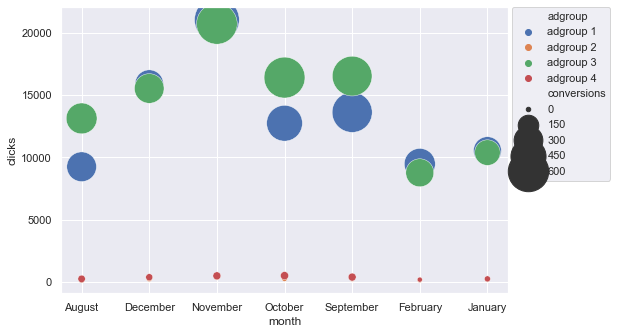

In [98]:
sns.scatterplot(data=df_month, x="month", y="clicks", size="conversions", hue="adgroup", legend="brief", sizes=(20, 2000))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

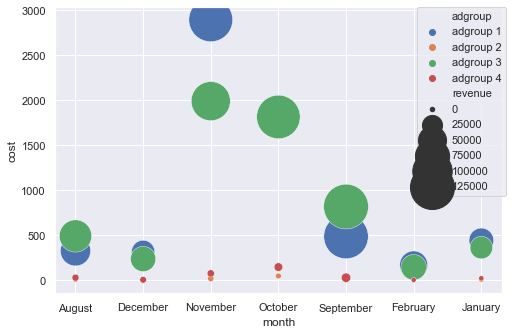

In [99]:
sns.scatterplot(data=df_month, x="month", y="cost", size="revenue", hue="adgroup", legend="brief", sizes=(20, 2000))
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

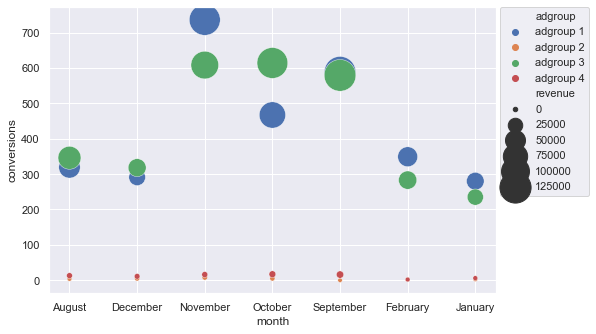

In [100]:
sns.scatterplot(data=df_month, x="month", y="conversions", size="revenue", hue="adgroup", sizes=(20, 1000),legend="brief")
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [101]:
new_train.head()

date    campaign    adgroup     ad  impressions  clicks  cost  \
0 2020-08-01  campaign 1  adgroup 1   ad 1           24       6  0.08   
1 2020-08-01  campaign 1  adgroup 1  ad 10            5       2  0.02   
2 2020-08-01  campaign 1  adgroup 1   ad 2          247     126  1.29   
3 2020-08-01  campaign 1  adgroup 1   ad 3          129      52  0.58   
4 2020-08-01  campaign 1  adgroup 1   ad 7           26      10  0.10   

   conversions  revenue       CTR       CPC     CPA         ROI  year  month  \
0            0     0.00  0.250000  0.013333     NaN    0.000000  2020      8   
1            0     0.00  0.400000  0.010000     NaN    0.000000  2020      8   
2            4   925.71  0.510121  0.010238  0.3225  717.604651  2020      8   
3            0     0.00  0.403101  0.011154     NaN    0.000000  2020      8   
4            0     0.00  0.384615  0.010000     NaN    0.000000  2020      8   

   dateOFmonth  
0            1  
1            1  
2            1  
3            1  
4            1

In [102]:
new_train['WEEKDAY'] = pd.to_datetime(new_train['date']).dt.dayofweek

In [103]:
new_train.head()

date    campaign    adgroup     ad  impressions  clicks  cost  \
0 2020-08-01  campaign 1  adgroup 1   ad 1           24       6  0.08   
1 2020-08-01  campaign 1  adgroup 1  ad 10            5       2  0.02   
2 2020-08-01  campaign 1  adgroup 1   ad 2          247     126  1.29   
3 2020-08-01  campaign 1  adgroup 1   ad 3          129      52  0.58   
4 2020-08-01  campaign 1  adgroup 1   ad 7           26      10  0.10   

   conversions  revenue       CTR       CPC     CPA         ROI  year  month  \
0            0     0.00  0.250000  0.013333     NaN    0.000000  2020      8   
1            0     0.00  0.400000  0.010000     NaN    0.000000  2020      8   
2            4   925.71  0.510121  0.010238  0.3225  717.604651  2020      8   
3            0     0.00  0.403101  0.011154     NaN    0.000000  2020      8   
4            0     0.00  0.384615  0.010000     NaN    0.000000  2020      8   

   dateOFmonth  WEEKDAY  
0            1        5  
1            1        5  
2            1        5  
3            1        5  
4            1        5

In [104]:
new_train["WEEKDAY"] = new_train["WEEKDAY"].astype(str)

In [105]:
new_train['WEEKDAY'] = new_train['WEEKDAY'].replace(['0','1','2','3','4','5','6'],
                              ['Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday','Sunday'])

<AxesSubplot:xlabel='WEEKDAY', ylabel='impressions'>

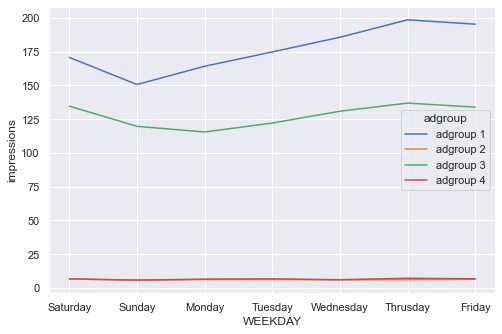

In [106]:
 sns.lineplot(x="WEEKDAY", y="impressions",
              hue="adgroup",
              data=new_train,ci = None)

<AxesSubplot:xlabel='WEEKDAY', ylabel='clicks'>

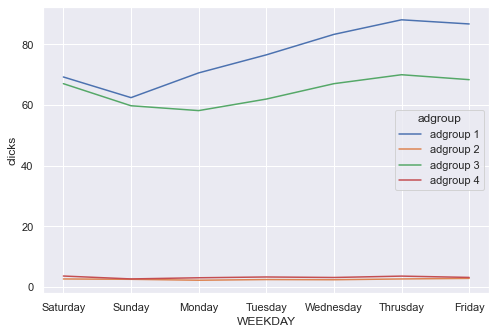

In [107]:
 sns.lineplot(x="WEEKDAY", y="clicks",
              hue="adgroup",
              data=new_train,ci = None)

<AxesSubplot:xlabel='WEEKDAY', ylabel='cost'>

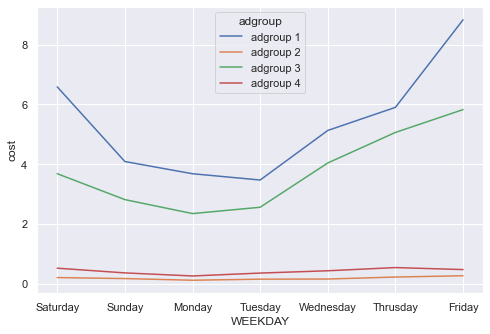

In [108]:
 sns.lineplot(x="WEEKDAY", y="cost",
              hue="adgroup",
              data=new_train,ci = None)

<AxesSubplot:xlabel='WEEKDAY', ylabel='conversions'>

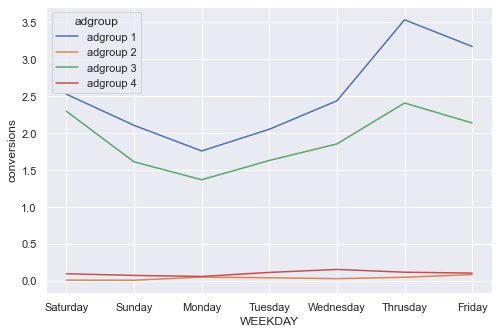

In [109]:
 sns.lineplot(x="WEEKDAY", y="conversions",
              hue="adgroup",
              data=new_train,ci = None)

<AxesSubplot:xlabel='WEEKDAY', ylabel='revenue'>

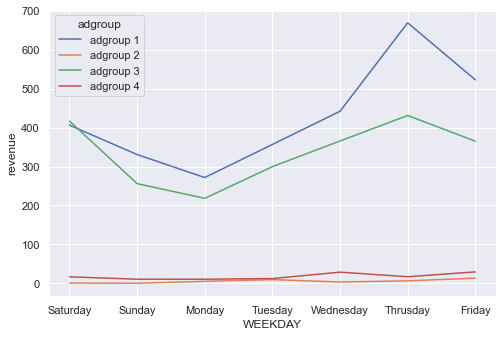

In [110]:
 sns.lineplot(x="WEEKDAY", y="revenue",
              hue="adgroup",
             data=new_train,ci = None)

### Based on this exercise we get to know, which days has most clicks, revenue, impressions, conversions

# Modelling : - 

In [111]:
df = pd.read_excel("data_train.xlsx")

In [112]:
df.head()

date    campaign    adgroup     ad  impressions  clicks  cost  \
0 2020-08-01  campaign 1  adgroup 1   ad 1           24       6  0.08   
1 2020-08-01  campaign 1  adgroup 1  ad 10            5       2  0.02   
2 2020-08-01  campaign 1  adgroup 1   ad 2          247     126  1.29   
3 2020-08-01  campaign 1  adgroup 1   ad 3          129      52  0.58   
4 2020-08-01  campaign 1  adgroup 1   ad 7           26      10  0.10   

   conversions  revenue       CTR       CPC     CPA         ROI  year  month  \
0            0     0.00  0.250000  0.013333     NaN    0.000000  2020      8   
1            0     0.00  0.400000  0.010000     NaN    0.000000  2020      8   
2            4   925.71  0.510121  0.010238  0.3225  717.604651  2020      8   
3            0     0.00  0.403101  0.011154     NaN    0.000000  2020      8   
4            0     0.00  0.384615  0.010000     NaN    0.000000  2020      8   

   dateOFmonth  
0            1  
1            1  
2            1  
3            1  
4            1

In [113]:
df.columns

Index(['date', 'campaign', 'adgroup', 'ad', 'impressions', 'clicks', 'cost',
       'conversions', 'revenue', 'CTR', 'CPC', 'CPA', 'ROI', 'year', 'month',
       'dateOFmonth'],
      dtype='object')

In [114]:
df = df[['date','adgroup', 'ad', 'impressions', 'clicks', 'cost',
                                       'conversions', 'revenue']]

In [115]:
df.head()

date    adgroup     ad  impressions  clicks  cost  conversions  \
0 2020-08-01  adgroup 1   ad 1           24       6  0.08            0   
1 2020-08-01  adgroup 1  ad 10            5       2  0.02            0   
2 2020-08-01  adgroup 1   ad 2          247     126  1.29            4   
3 2020-08-01  adgroup 1   ad 3          129      52  0.58            0   
4 2020-08-01  adgroup 1   ad 7           26      10  0.10            0   

   revenue  
0     0.00  
1     0.00  
2   925.71  
3     0.00  
4     0.00

In [116]:
df.shape

(4237, 8)

In [117]:
df.head()

date    adgroup     ad  impressions  clicks  cost  conversions  \
0 2020-08-01  adgroup 1   ad 1           24       6  0.08            0   
1 2020-08-01  adgroup 1  ad 10            5       2  0.02            0   
2 2020-08-01  adgroup 1   ad 2          247     126  1.29            4   
3 2020-08-01  adgroup 1   ad 3          129      52  0.58            0   
4 2020-08-01  adgroup 1   ad 7           26      10  0.10            0   

   revenue  
0     0.00  
1     0.00  
2   925.71  
3     0.00  
4     0.00

#### Split data for training and testing 

In [118]:
X = df.drop(["impressions","clicks", "conversions", "revenue"], axis = 1)
y = df[["impressions","clicks", "conversions", "revenue"]]

In [119]:
X

date    adgroup     ad  cost
0    2020-08-01  adgroup 1   ad 1  0.08
1    2020-08-01  adgroup 1  ad 10  0.02
2    2020-08-01  adgroup 1   ad 2  1.29
3    2020-08-01  adgroup 1   ad 3  0.58
4    2020-08-01  adgroup 1   ad 7  0.10
...         ...        ...    ...   ...
4232 2021-02-28  adgroup 3   ad 8  1.37
4233 2021-02-28  adgroup 4   ad 1  0.00
4234 2021-02-28  adgroup 4   ad 2  0.00
4235 2021-02-28  adgroup 4   ad 3  0.03
4236 2021-02-28  adgroup 4  ad 55  0.00

[4237 rows x 4 columns]

### Set index into date

In [120]:
X.set_index("date",inplace = True)

## Create dummy variabel : - Adgroup 

In [127]:
X= pd.get_dummies(X,
                     columns = ['adgroup'],drop_first=True)

### Label encode for ad variable 

In [128]:
# label_encoder object knows how to understand word labels.
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
  # Encode labels in column 'species'.
X['ad']= label_encoder.fit_transform(X['ad'])

In [129]:
X.head()

ad  cost  adgroup_adgroup 2  adgroup_adgroup 3  adgroup_adgroup 4
date                                                                         
2020-08-01   0  0.08                  0                  0                  0
2020-08-01   1  0.02                  0                  0                  0
2020-08-01  11  1.29                  0                  0                  0
2020-08-01  22  0.58                  0                  0                  0
2020-08-01  66  0.10                  0                  0                  0

### For training : - split teaining data into train and test

In [130]:
x_train = X[:3628]
x_test = X[3628:]
y_train = y[:3628]
y_test = y[3628:]

### Random Forest model 

In [131]:
rf = RandomForestRegressor(random_state=48)

In [132]:
rf.fit(x_train,y_train)

RandomForestRegressor(random_state=48)

## Predict test

In [133]:
pred = rf.predict(x_test)

In [134]:
columns = ["impressions","clicks","conversions","revenue"]
prediction = pd.DataFrame(pred,columns = columns)

In [135]:
prediction["impressions"] = prediction["impressions"].apply(np.ceil)
prediction["clicks"] = prediction["clicks"].round(0).apply(np.ceil)
prediction["conversions"] = prediction["conversions"].apply(np.ceil)

In [136]:
y_test

impressions  clicks  conversions  revenue
3628           11       2            0     0.00
3629            7       5            0     0.00
3630          674     289            7   872.92
3631           22       6            0     0.00
3632           11       6            1    30.90
...           ...     ...          ...      ...
4232          261     106            3   404.17
4233            4       0            0     0.00
4234            2       0            0     0.00
4235            9       2            0     0.00
4236            1       0            0     0.00

[609 rows x 4 columns]

In [137]:
prediction

impressions  clicks  conversions      revenue
0            9.0     3.0          0.0     0.000000
1           18.0     6.0          1.0     1.279524
2          591.0   281.0         10.0  1015.737600
3           42.0    11.0          1.0   379.032691
4           19.0     8.0          1.0     0.335000
..           ...     ...          ...          ...
604        262.0   126.0          3.0   530.122300
605          2.0     0.0          0.0     0.000000
606          3.0     0.0          0.0     0.000000
607          6.0     2.0          0.0     0.000000
608          2.0     0.0          0.0     0.000000

[609 rows x 4 columns]

## Mean Squared error

In [138]:
mean_squared_error(y_test,prediction)

63795.833057319